# SET 3125 Project Outline ---- DC-OPF





## Background of the Project


The goal of this project is to develop a machine learning model **to predict the results of a DC Optimal Power Flow (DC-OPF) for a 14-bus power system**. You need to train a supervised learning regression model using historical data generated from DC-OPF solutions (provided already). By doing so, we aim to create a fast and reliable model that can be used in real-time operations, bypassing the need for computationally expensive optimization solvers.

The **features** of the dataset are the power demands at different buses while the **labels** are the generator set points that satisfy the optimal power flow conditions.

In the following, we provide some background information for DC-OPF, such that you may have a better understanding of the problem.

### DC-OPF Formulation

DC Optimal Power Flow (DC-OPF) is a linearized version of the (AC) Optimal Power Flow problem that is used to determine the optimal operating points of generators in a power system in terms of minimizing generation costs while meeting load demands and adhering to system constraints. The DC-OPF formulation involves:

1. **Objective Function**: Minimize the total cost of power generation.
  
   $$\min_{P_{G_i}} \quad \sum_{i \in N} C(P_{G_i})=aP_{G_i}$$
   Where $ C(P_{G_i})$ is the cost function associated with the power generated by generator $G_i$. The objective is to minimize the total generation cost while ensuring the system operates reliably. Note that if there is no generator connected on bus $i$, then $P_{G_i}=0$.

2. **Power Balance Equation**: At each bus, the generated power minus the load demand must be balanced by the net power flow into or out of the bus.
   
   $$
   \sum_{(i,j)\in L}F_{ij} = P_{G_i} - P_{D_i}, \quad \forall i \in N
  $$
   
   Here, $F_{ij}$ represents the power flow from bus $i$ to bus $j$ through transmission line $ij$ (*positive* means flows out). $P_{D_i}$ represents the load demand at bus $i$.

3. **Power Flow Equations**: Power flow between buses is modeled as a linear function of the voltage angle difference between buses:
   
   $$
   F_{ij} = B_{ij} (	\theta_i - 	\theta_j), \quad \forall (i, j) \in L
   $$
   
   Where $ B_{ij} $ is the susceptance of the line between bus $ i $ and bus $ j $, and $ 	\theta_i - 	\theta_j $ represents the voltage angle difference. This equation is used to calculate the power flowing on the transmission lines.

4. **Flow Limits**: Each transmission line has a power flow limit that must not be exceeded to ensure system security:
   
   $$
   F_{ij}^{	\text{min}}\leq F_{ij} \leq F_{ij}^{	\text{max}}, \quad \forall (i, j) \in L$$

## Basic Workflow with Fully Connected Neural Network (FNN)





### 0. Import and install necessary libraries

In [1]:
!pip install torch-geometric
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 71.9 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch_geometric.utils as utils
import matplotlib
import networkx as nx
import math
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import ChebConv, GraphConv, GCNConv
from torch.nn import Linear
from torch.nn import Parameter
from itertools import product
import gurobipy as gp
from gurobipy import GRB

### 1. Dataset loading, inspection, and preparation

In [3]:
# Mount google drive if you use google colab, otherwise comment out this cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset by inserting your file directory
load_demand = np.load('/content/load_demands 1.npy')
generator_supply = np.load('/content/generator_supplies 1.npy')
print(load_demand.shape)
print(generator_supply.shape)
print(load_demand[:5])
print(generator_supply[:5])

(52032, 14)
(52032, 5)
[[0.         0.13904758 0.64886898 0.30768856 0.05090729 0.07672653
  0.         0.         0.19730154 0.05606943 0.02353119 0.04239375
  0.08435596 0.09373867]
 [0.         0.12762219 0.52879773 0.29974378 0.04353354 0.06250509
  0.         0.         0.1733137  0.05923808 0.02172206 0.03659696
  0.09183128 0.08938149]
 [0.         0.12351404 0.59230802 0.26311991 0.0423603  0.07386163
  0.         0.         0.17856678 0.05590844 0.0203625  0.03517492
  0.09021444 0.08880838]
 [0.         0.14040292 0.61593315 0.29345871 0.04960821 0.06583489
  0.         0.         0.18835958 0.05378189 0.01962312 0.03680717
  0.08983804 0.0884082 ]
 [0.         0.13435623 0.62526604 0.31610164 0.04952549 0.07453162
  0.         0.         0.19697592 0.0501033  0.02299207 0.03997732
  0.07639088 0.09906295]]
[[1.03729615 0.35       0.16666667 0.08333333 0.08333333]
 [0.831      0.35       0.16666667 0.1032859  0.08333333]
 [0.831      0.35       0.16666667 0.13319937 0.0833333

### Task 1


*   (1) Check the distributions of the load demands and gnerator supplies, are there outliers? Comment on how you would remove them if any
*   (2) Look at the total demand for each data sample each sample, does it match total supply?



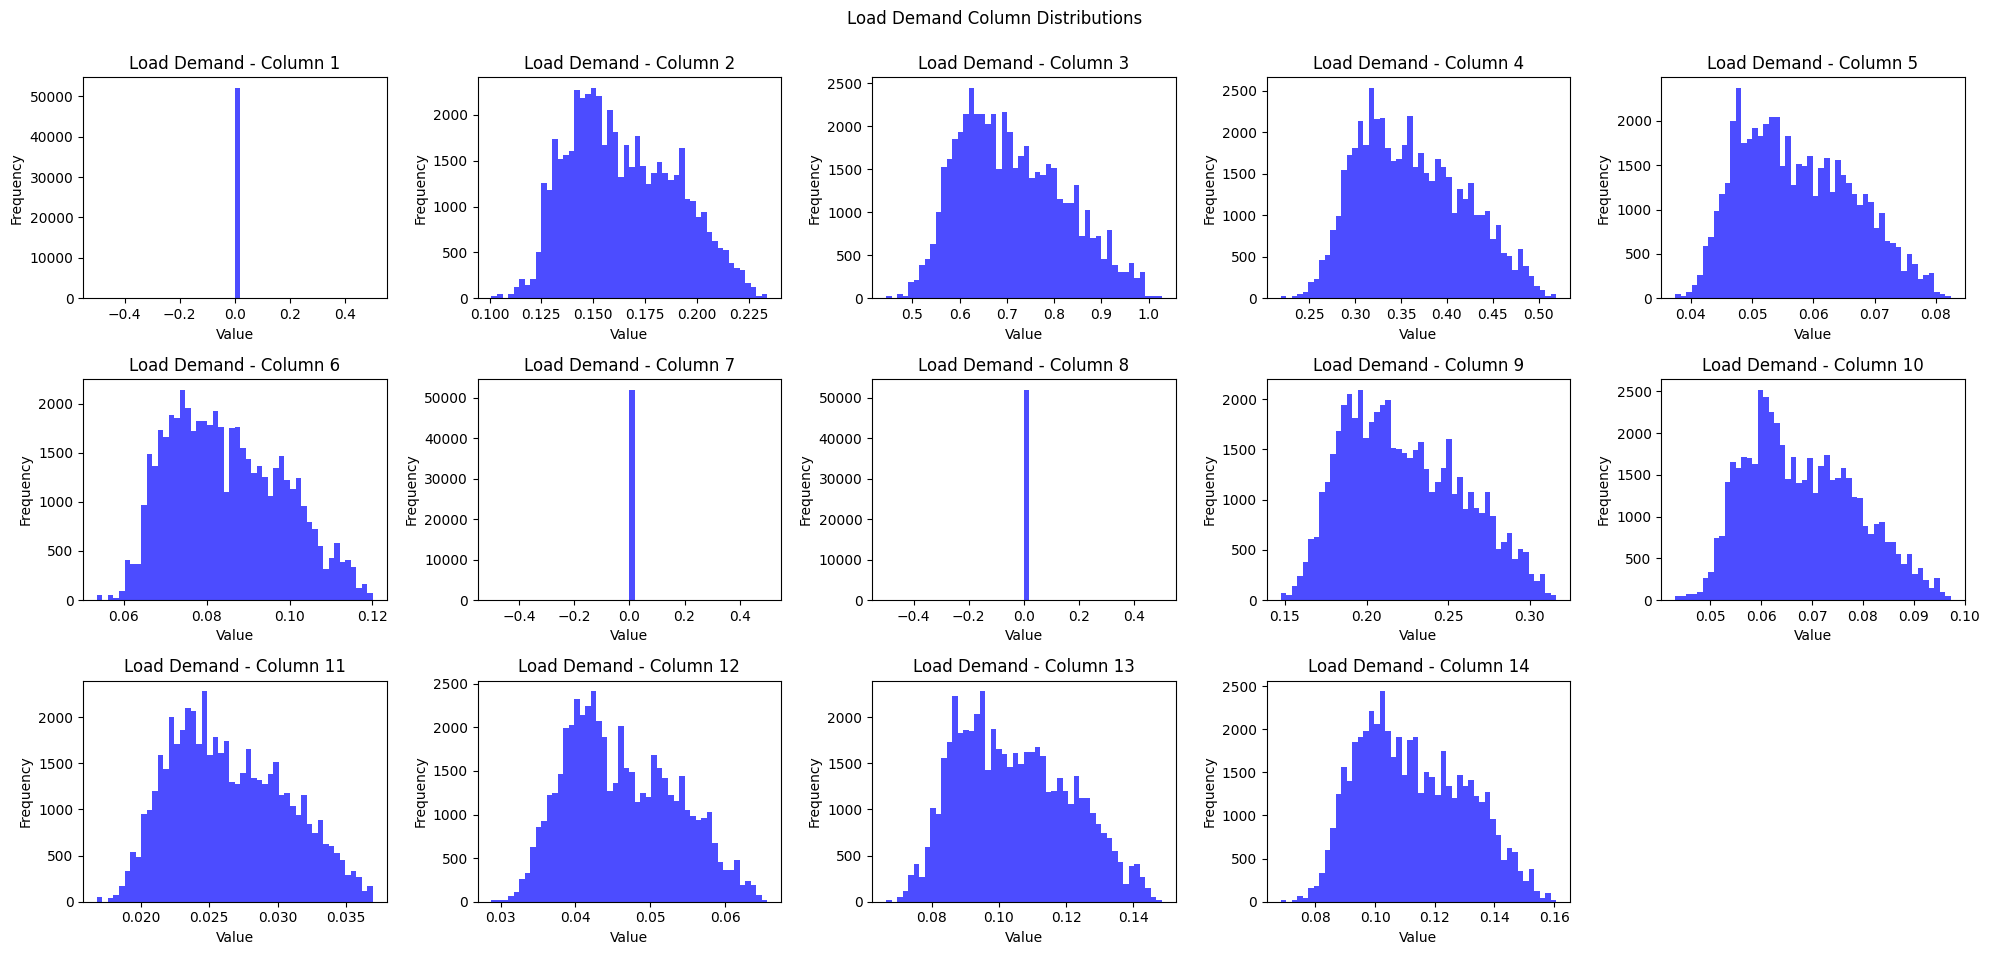

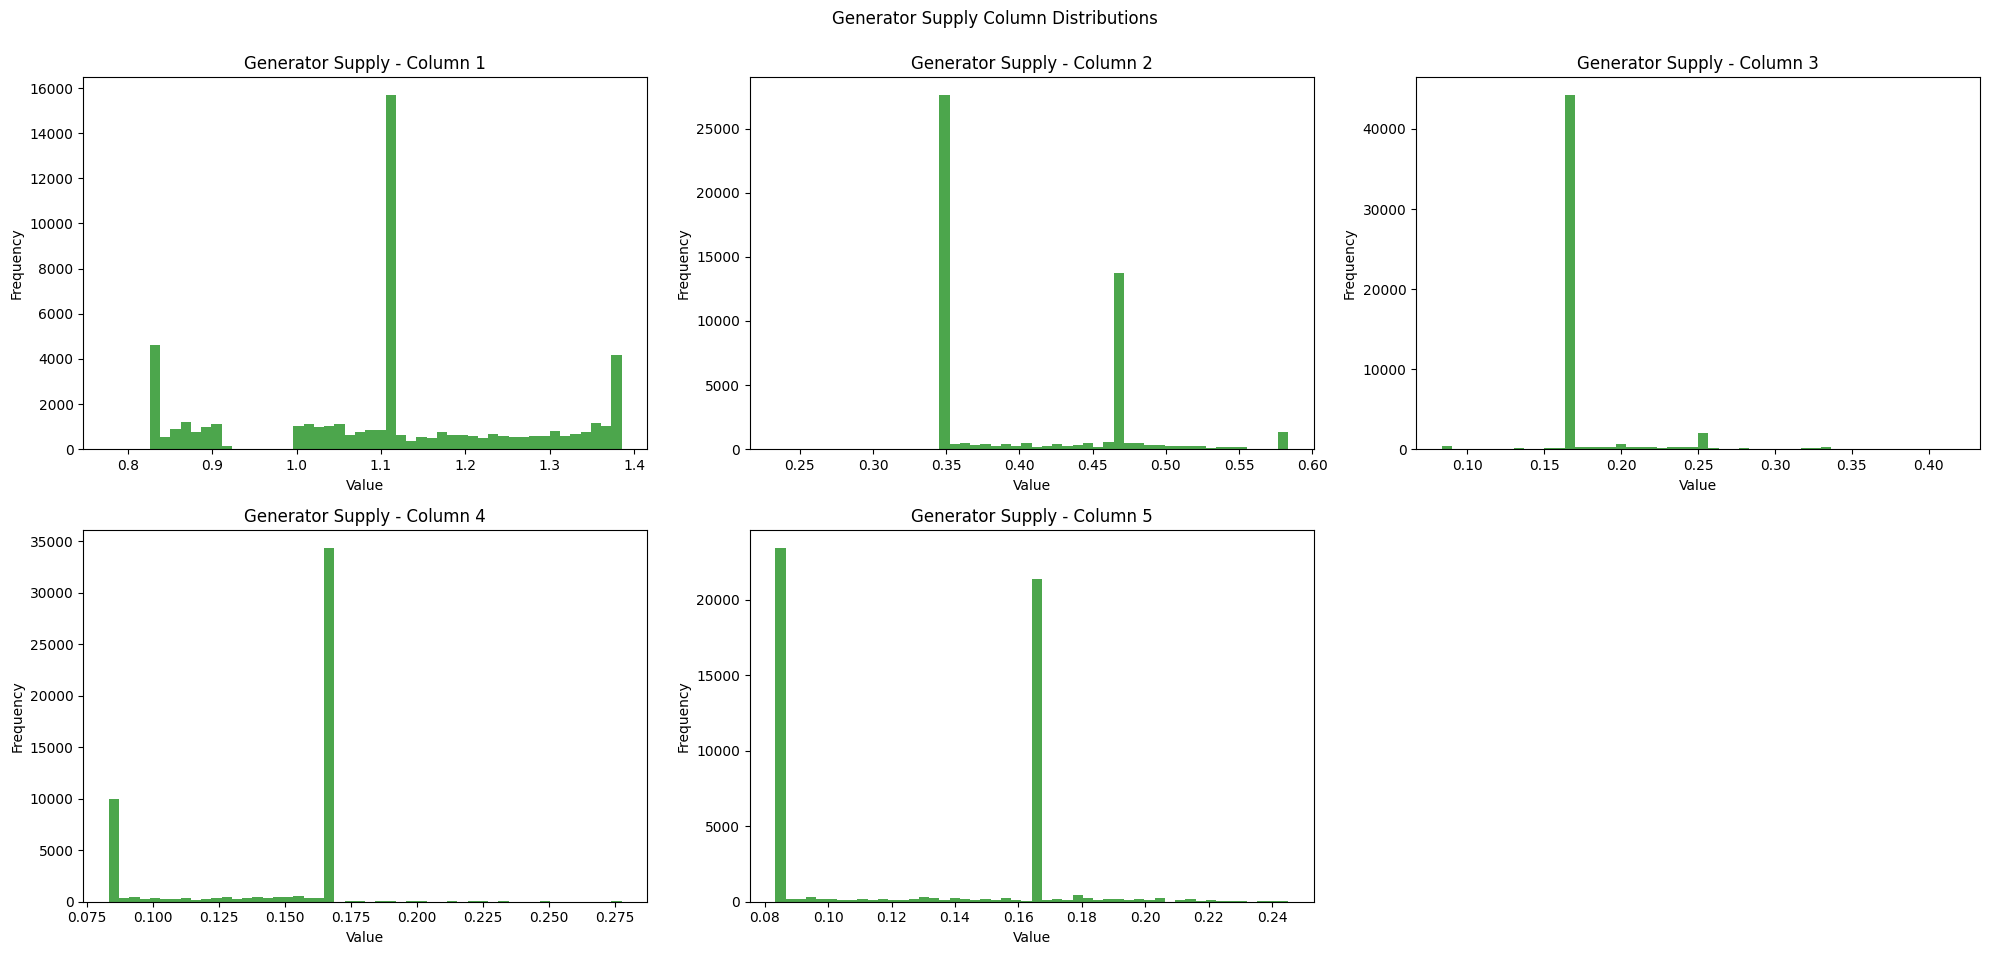

In [5]:
# (1)
# Plot histograms for Load Demand
plt.figure(figsize=(20, 10))
for i in range(load_demand.shape[1]):
    plt.subplot(3, 5, i + 1)  # Adjust grid size to fit 14 columns
    plt.hist(load_demand[:, i], bins=50, alpha=0.7, color='blue')
    plt.title(f"Load Demand - Column {i+1}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for titles
plt.suptitle("Load Demand Column Distributions")
plt.show()

# Plot histograms for Generator Supply
plt.figure(figsize=(20, 10))
for i in range(generator_supply.shape[1]):
    plt.subplot(2, 3, i + 1)  # Adjust grid size to fit 5 columns
    plt.hist(generator_supply[:, i], bins=50, alpha=0.7, color='green')
    plt.title(f"Generator Supply - Column {i+1}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for titles
plt.suptitle("Generator Supply Column Distributions")
plt.show()


Most columns in the **load_demand** dataset have a shape similar to a gaussian curve with no clear outliers. In the **generator_supply** dataset, most shapes do not look like a bell curve, and the histograms suggest there could be some outliers—for example, in ***Column 2***, it is over a range where some values are between 0.55 and 0.6. It is not clear from the question, but in case there are outliers, one good way to handle them would be using **standardization**. It does not remove the outliers directly, though it does attenuate their impact on most of the algorithms.








In [6]:
#(2)
# Let's now check that total demand match total supply for the first 50 observations:
for i in range(50):
  list_a = []
  a = sum(load_demand[i])
  b = sum(generator_supply[i])
  list_a.append(a-b)
  print('Difference between demand and supply for row', i, ': ', list_a[0])

Difference between demand and supply for row 0 :  2.220446049250313e-16
Difference between demand and supply for row 1 :  -2.220446049250313e-15
Difference between demand and supply for row 2 :  1.1102230246251565e-15
Difference between demand and supply for row 3 :  2.220446049250313e-16
Difference between demand and supply for row 4 :  0.0
Difference between demand and supply for row 5 :  2.220446049250313e-16
Difference between demand and supply for row 6 :  2.220446049250313e-16
Difference between demand and supply for row 7 :  -6.661338147750939e-16
Difference between demand and supply for row 8 :  1.3322676295501878e-15
Difference between demand and supply for row 9 :  0.0
Difference between demand and supply for row 10 :  2.220446049250313e-16
Difference between demand and supply for row 11 :  -2.220446049250313e-16
Difference between demand and supply for row 12 :  8.881784197001252e-16
Difference between demand and supply for row 13 :  -2.220446049250313e-16
Difference between

We observe that the **total load** and the **total demand** for each observation are consistently equal, with a very small difference on the order of 10^(-16).
 For computational efficiency, this is demonstrated here using the first 50 observations; however, it can be assumed to hold true for all rows. This suggests that **generator_supply** is meeting **load_demand**.

In [7]:
if torch.cuda.is_available():
  print("Training on GPU")
  device = torch.device("cuda:0")
else:
  print("Training on CPU")
  device = torch.device("cpu")

Training on CPU


### 2. Model definition

A tutorial on defining a NN with torch: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#

In [8]:
# Define the model, e.g., with torch write a simple feedforward network
class FF_DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,num_layers):
        super(FF_DNN, self).__init__()
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim=hidden_dim

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for _ in range(num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):

        out = self.model(x)
        return out

### 3. Functions

- dataset spliting function
- loss function
- training function (train)
- validation function (eval)
- test function (test)
- Hyperparameter multiple run function

In [9]:
# dataset splitting function, we use ratio [66.6:16.6:16.6]
def split_data(x_data,y_data):

  train_size = int((x_data.shape[0]//3) * 2)
  val_size = int((x_data.shape[0]//3) / 2)
  test_size = int((x_data.shape[0]//3) / 2)

  train_x = x_data[:train_size,:]
  val_x = x_data[train_size:train_size+val_size,:]
  test_x = x_data[train_size+val_size:,:]

  train_y = y_data[:train_size,:]
  val_y = y_data[train_size:train_size+val_size,:]
  test_y = y_data[train_size+val_size:,:]

  return train_x, val_x, test_x , train_y, val_y, test_y

In [10]:
# we define a simple loss function
def simple_loss(y_pred, y):
  loss_fn = nn.MSELoss()
  loss = loss_fn(y_pred, y)
  return loss

In [11]:
# model training function
def train_fnn(model, loader, criterion, optimizer, device=device):
    model.to(device)
    model.train() # specifies that the model is in training mode

    epoch_loss = 0
    model.train()
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [12]:
# model evaluation function
@torch.no_grad()
def evaluate_fnn(model, loader, criterion, device=device):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [13]:
# model testing function

def test_fnn(model, loader, criterion, device=device):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode
    epoch_loss = 0
    model.eval()

    model_preds = []
    actual_y = []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            model_preds.append(y_pred)
            actual_y.append(y)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()


    return epoch_loss / len(loader), model_preds,actual_y

In [14]:
# simple  function to create multiple run instances of model training for best hyperparameter selection

def create_hyper_combination_FNN(h_feat, l_feat):
    parameters = dict(
      hid_features= h_feat,
      num_layers= l_feat
  )

    param_values = [v for v in parameters.values()]
    print(param_values)

    for  hid_features, num_layers in product(*param_values):
        print(hid_features, num_layers)

    return param_values

### 4. Training setup

Execute dataset split and specify batchsize.



In [15]:
# Convert data to torch tensors and split the dataset
x_data = torch.tensor(load_demand).float()
y_data = torch.tensor(generator_supply).float()

train_x, val_x, test_x , train_y, val_y, test_y = split_data(x_data, y_data)
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#### Here is an example standard FNN model training. We:

- perform the loop over a specified number of epochs
- optimiser setup
- NN model instantiation
- Print output / plot training progress

In [16]:
# specify the model input and output dimensions
N_input_features = 14
N_output_features = 5

Epoch: 0
	Train Loss: 0.005
	 Val. Loss: 0.001


[]

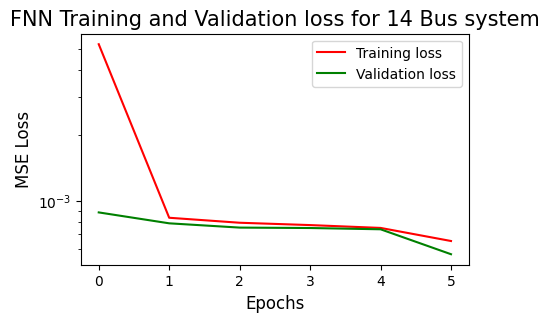

In [17]:
# create a model instance and train model for one run, model hyperparameters are fixed as 16 and 4 here
model = FF_DNN(N_input_features, 16, N_output_features,4)

# specify optimizer and other model details
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

training_losses = []
validation_losses = []
best_valid_loss = float('inf')
early_stop_thresh = 20
epochs = 5 #change this before submitting
best_epoch = -1
for epoch in range(epochs+1):
  train_loss = train_fnn(model, train_loader, simple_loss, optimizer)
  valid_loss = evaluate_fnn(model, val_loader, simple_loss)
  training_losses.append(train_loss)
  validation_losses.append(valid_loss)


  scheduler.step(valid_loss)

  if epoch % 10 == 0:
      print(f'Epoch: {epoch}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f}')
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss

training_losses=np.array(training_losses)
validation_losses=np.array(validation_losses)

plt.subplots(figsize=(5,3))
plt.plot([i for i in range(len(training_losses))], training_losses, 'r', label='Training loss')
plt.plot([i for i in range(len(validation_losses))], validation_losses, 'g', label='Validation loss')
plt.legend()
plt.title(f'FNN Training and Validation loss for 14 Bus system',fontsize = 15)
plt.xlabel('Epochs',fontsize = 12)
plt.ylabel('MSE Loss',fontsize = 12)
plt.semilogy()

### 5. Training with hyperparameter combinations

### Task 5



1.   Use the different hyperparameter combinations we have provided with 'create_hyper_combination_FNN' function above to create 6 runs

2.   Comment on the influence of model hyperparameters on the model accuracy

3. Use the model with the best hyperparameter combination for subsequent evaluations





In [18]:
## insert the rest of your code here

h_feat = [32, 64]
l_feat = [2, 3, 4]

# specify the hyperparameter selections
param_values = create_hyper_combination_FNN(h_feat, l_feat)
print(param_values)

[[32, 64], [2, 3, 4]]
32 2
32 3
32 4
64 2
64 3
64 4
[[32, 64], [2, 3, 4]]


### Model hyperparameters strongly influence accuracy by controlling model complexity and performances as follows:
 - A low learning rate ensures stable convergence but can be slow, while a high rate risks instability.
 - Small batch sizes introduce noise, improving generalization, while large sizes lead to smoother but potentially not optimal results.
 - The number of layers and neurons must balance underfitting and overfitting, bias and variance.
 - Regularization prevents overfitting, and optimizers like Adam improve convergence.

In [19]:
# insert code here

all_test_losses = []

trained_models = []

for run_number, (hidden_dim,num_layers) in enumerate(product(*param_values)):
  print("run number:", run_number + 1)

  #create simple model instance
  model = FF_DNN(N_input_features, 16, N_output_features, 4)

  # specify optimizer and other model details
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-5)
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

  training_losses = []
  validation_losses = []
  test_losses = []

  best_valid_loss = float('inf')
  early_stop_thresh = 20
  epochs = 20 #20 epochs are enough to get the best combination of hyper-parameters
  best_epoch = -1
  # insert code here, follow the same structure as example training
  for epoch in range(epochs+1):
    test_losses = []
    train_loss = train_fnn(model, train_loader, simple_loss, optimizer)
    valid_loss = evaluate_fnn(model, val_loader, simple_loss)
    training_losses.append(train_loss)
    validation_losses.append(valid_loss)
    scheduler.step(valid_loss)
    test_loss, model_preds,actual_y = test_fnn(model, test_loader, simple_loss)
    test_losses.append(test_loss)

    trained_models.append(model)
    all_test_losses.append(test_losses)

    print("test loss:", np.array(test_losses))

print('finished all runs with different hyperparameters!')

test_losses_matrix = np.array(all_test_losses).reshape(6,epochs+1)
print("\nTest Loss Matrix:\n", test_losses_matrix)

last_elements = test_losses_matrix[:, -1]
index_of_min = np.argmin(last_elements)
best_run = test_losses_matrix[index_of_min]

print("\nBest run:")
print(best_run)

run number: 1
test loss: [0.00109916]
test loss: [0.0010776]
test loss: [0.00085682]
test loss: [0.00085854]
test loss: [0.00078652]
test loss: [0.00078255]
test loss: [0.00077158]
test loss: [0.00076506]
test loss: [0.00074333]
test loss: [0.00063418]
test loss: [0.00056879]
test loss: [0.00058765]
test loss: [0.00057557]
test loss: [0.00053077]
test loss: [0.00054404]
test loss: [0.0005365]
test loss: [0.00058079]
test loss: [0.00050797]
test loss: [0.00047375]
test loss: [0.00044917]
test loss: [0.000432]
run number: 2
test loss: [0.0011724]
test loss: [0.00088473]
test loss: [0.00085874]
test loss: [0.00070232]
test loss: [0.00048847]
test loss: [0.00048691]
test loss: [0.00047222]
test loss: [0.00046667]
test loss: [0.00046066]
test loss: [0.00046337]
test loss: [0.00047256]
test loss: [0.00046955]
test loss: [0.00047712]
test loss: [0.00047449]
test loss: [0.00045362]
test loss: [0.00045372]
test loss: [0.00044827]
test loss: [0.00044906]
test loss: [0.00044498]
test loss: [0.000

In [20]:
print(len(model_preds))

542


**For 20 epochs, the array "Best run" represents the one which minimized test loss. Thus, the evaluations will continue for a NN architecture of width and depth equal to the combination of hyperparameters chosen for the best run.**

### 6. Understand predictions

To ensure the model is working as we would expect, perform the following sanity checks:

### Task 6


*   (1) Plot an histogram of prediction errors, what type of distribution do you obtain?
*   (2) For the test data, plot the mismatch between the sum of demands and sum of predicted generator supply? What is the maximum mismatch? What is the mean mismatch?



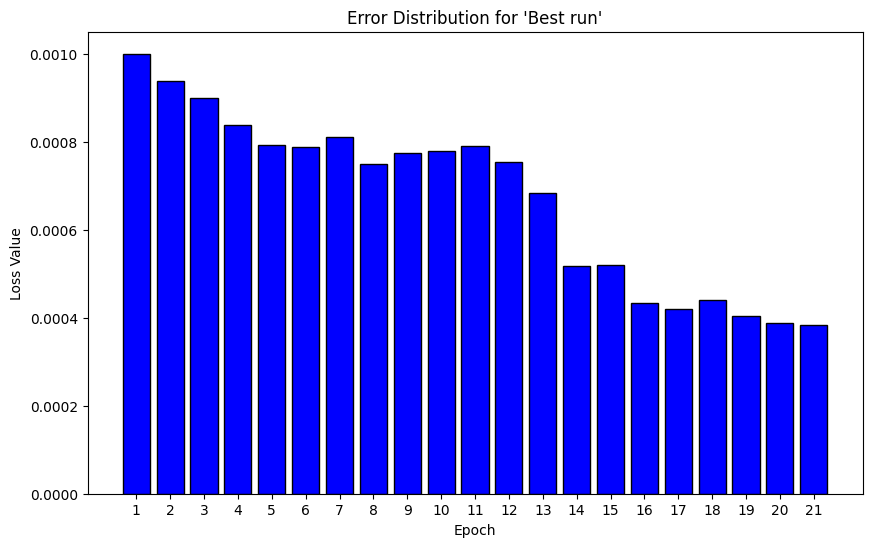

In [21]:
# Assumption: since it is not specified, the histograms will be related ONLY to the optimal set of hyper-parameters.
# Plot the histogram of errors
plt.figure(figsize=(10, 6))
positions = range(1, len(best_run) + 1)  # X-axis
plt.bar(positions, best_run, color='blue', edgecolor='black')

plt.title("Error Distribution for 'Best run'")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.xticks(positions)

plt.show()

**Errors decrease with an hyperbolic trend that seems to have stabilized around epoch 10.**

In [22]:
# Function to compute the total power demand minus the total power injection.
def compute_power_balance_mismatch(x, y):
  #insert code here
  power_balance_mismatch = a - b
  return power_balance_mismatch

In [23]:
# add code to compute the maximum and mean power balance mismatch between the load demand and true generator supply here. HINT - values should be very close to zero
true_mismatch = []

for i in range(len(load_demand)):
    a = sum(load_demand[i]) #x is the sum of all load demands on a row
    b = sum(generator_supply[i]) #y is the sum of all generator supplies on a row
    true_mismatch.append(compute_power_balance_mismatch(a, b))

max_true_mismatch = np.max(np.abs(true_mismatch))
mean_true_mismatch = np.mean(np.abs(true_mismatch))

print('Maximum true mismatch between the load demand and true generator supply is: ', max_true_mismatch)
print('Mean true mismatch between the load demand and true generator supply is: ', mean_true_mismatch)

Maximum true mismatch between the load demand and true generator supply is:  4.6629367034256575e-15
Mean true mismatch between the load demand and true generator supply is:  4.436966033069141e-16


In [24]:
# add code to compute the maximum and mean power balance mismatch between the load demand and predicted generator supply here

flat_model_preds = [row.numpy() for tensor in model_preds for row in tensor] # necessary to adapt lists sizes as shown
print(len(test_x))
print(len(flat_model_preds))
print('I just checked for equal lengths!')
# Compute power balance mismatch
predicted_mismatch = []

for i in range(len(test_x)):
    a = sum(test_x[i]) #x is the sum of all load demands on a row
    b = sum(flat_model_preds[i]) #y is the sum of all generator supplies on a row
    predicted_mismatch.append(compute_power_balance_mismatch(a, b))

max_predicted_mismatch = np.max(np.abs(predicted_mismatch))
mean_predicted_mismatch = np.mean(np.abs(predicted_mismatch))

print('Maximum power balance mismatch between the load demand and predicted generator supply is: ', max_predicted_mismatch)
print('Mean power balance mismatch between the load demand and predicted generator supply is: ', mean_predicted_mismatch)

8672
8672
I just checked for equal lengths!
Maximum power balance mismatch between the load demand and predicted generator supply is:  0.19773638
Mean power balance mismatch between the load demand and predicted generator supply is:  0.01813932


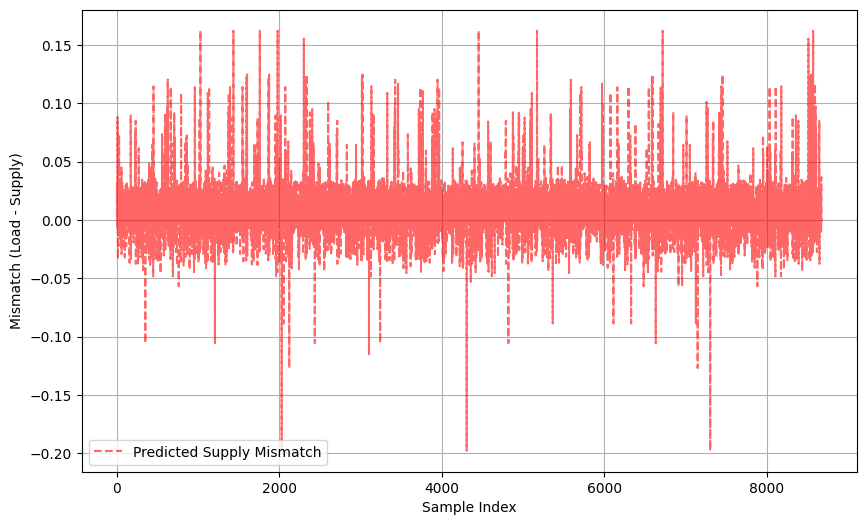

In [25]:
# add your code for line plot of mismatch here:

plt.figure(figsize=(10, 6))
plt.plot(predicted_mismatch, label="Predicted Supply Mismatch", color="red", linestyle="--", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Mismatch (Load - Supply)")
plt.legend()
plt.grid(True)
plt.show()

## Physics-Informed Training

In this section, we will investigate how we can include physics in the training process and how it affects the training performance.


### 1. The underlying physics

We have seen how much the previous model obeys the underlying physics, which requires that the sum of total demand should match the sum of total supply. Now we would define a physics loss to improve the satisfaction of the power balance constraint.

In [26]:
# we define a weight for physics loss here

physics_loss_weight = 0.1

### Task 1

Write the physics informed loss function using the power balance mismatch function provided

In [27]:
from re import A
# we define physics loss, add code here
def extra_loss(x, y_pred):
  # insert code here
  physics_loss_weight = 0.1
  a = compute_power_balance_mismatch(x, y_pred)
  phy_loss = a**2
  return phy_loss * physics_loss_weight

### 2. Adapt functions

To include the physics in the training process, we adapt the train_epoch and evaluate_epoch functions by adding the physics-informed loss term.

In [28]:
# adjust the training function to include the physics
def train_fnn_with_physics(model, loader, criterion, extra_loss, optimizer, device=device):
    model.to(device)
    model.train() # specifies that the model is in training mode

    epoch_loss = 0
    model.train()
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        data_loss = criterion(y_pred, y)
        physics_loss = extra_loss(x, y_pred)
        loss = data_loss + physics_loss
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [29]:
# adjust the evaluation function to include the physics
@torch.no_grad()
def evaluate_fnn_with_physics(model, loader, criterion, extra_loss, device=device):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            data_loss = criterion(y_pred, y)
            physics_loss = extra_loss(x, y_pred)
            loss = data_loss + physics_loss
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

### 3. Training

To perform the training, we only need to exchange the training and validation function.

Epoch: 0
	Train Loss: 0.004
	 Val. Loss: 0.001 -- without physics: 0.001
Epoch: 10
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
test loss: 0.000174849142357881


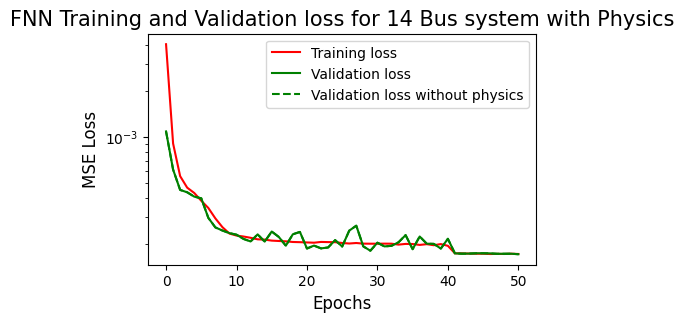

In [30]:
trained_models_with_physics = []

# specify the model input and output dimensions
N_input_features = 14
N_output_features = 5
hidden_dim = 64
num_layers = 4
#create simple model instance
model = FF_DNN(N_input_features, hidden_dim, N_output_features,num_layers)

# specify optimizer and other model details
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

training_losses = []
validation_losses = []
validation_losses_without_physics = []
best_valid_loss = float('inf')
early_stop_thresh = 20
epochs = 50
best_epoch = -1
for epoch in range(epochs+1):

  train_loss = train_fnn_with_physics(model, train_loader, simple_loss,extra_loss, optimizer)
  valid_loss = evaluate_fnn_with_physics(model, val_loader, simple_loss,extra_loss)
  valid_loss_without_physics = evaluate_fnn(model, val_loader, simple_loss)
  training_losses.append(train_loss)
  validation_losses.append(valid_loss)
  validation_losses_without_physics.append(valid_loss_without_physics)

  scheduler.step(valid_loss)

  if epoch % 10 == 0:
      print(f'Epoch: {epoch}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} -- without physics: {valid_loss_without_physics:.3f}')
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss

training_losses=np.array(training_losses)
validation_losses=np.array(validation_losses)
validation_losses_without_physics = np.array(validation_losses_without_physics)

plt.subplots(figsize=(5,3))
plt.plot([i for i in range(len(training_losses))], training_losses, 'r', label='Training loss')
plt.plot([i for i in range(len(validation_losses))], validation_losses, 'g', label='Validation loss')
plt.plot([i for i in range(len(validation_losses_without_physics))], validation_losses_without_physics, 'g--', label='Validation loss without physics')
plt.legend()
plt.title(f'FNN Training and Validation loss for 14 Bus system with Physics',fontsize = 15)
plt.xlabel('Epochs',fontsize = 12)
plt.ylabel('MSE Loss',fontsize = 12)
plt.semilogy()

test_loss, model_preds,actual_y = test_fnn(model, test_loader, simple_loss)

trained_models_with_physics.append(model)
print("test loss:", np.array(test_loss))


### 4. Understand the effect of the physics regularisation

As we did in the previous section, we check again how well the physics are satisfied and the effect on the prediction error distribution.

### Task 4

1.   Check how well the power balance constraint is satisfied now with the physics loss included by computing the maximum and mean power balance mismatches
2.   Plot the error distribution and comment on the type of distribution



In [31]:
# insert code here

flat_model_preds = [row.numpy() for tensor in model_preds for row in tensor] # necessary to adapt lists sizes as shown
print(len(test_x))
print(len(flat_model_preds))
print('I just checked for equal lengths!')
# Compute power balance mismatch
predicted_mismatch = []

for i in range(len(test_x)):
    a = sum(test_x[i]) #x is the sum of all load demands on a row
    b = sum(flat_model_preds[i]) #y is the sum of all generator supplies on a row
    predicted_mismatch.append(compute_power_balance_mismatch(a, b))

max_predicted_mismatch = np.max(np.abs(predicted_mismatch))
mean_predicted_mismatch = np.mean(np.abs(predicted_mismatch))

print('Maximum power balance mismatch between the load demand and predicted generator supply is: ', max_predicted_mismatch)
print('Mean power balance mismatch between the load demand and predicted generator supply is: ', mean_predicted_mismatch)

8672
8672
I just checked for equal lengths!
Maximum power balance mismatch between the load demand and predicted generator supply is:  0.17411375
Mean power balance mismatch between the load demand and predicted generator supply is:  0.0079537975


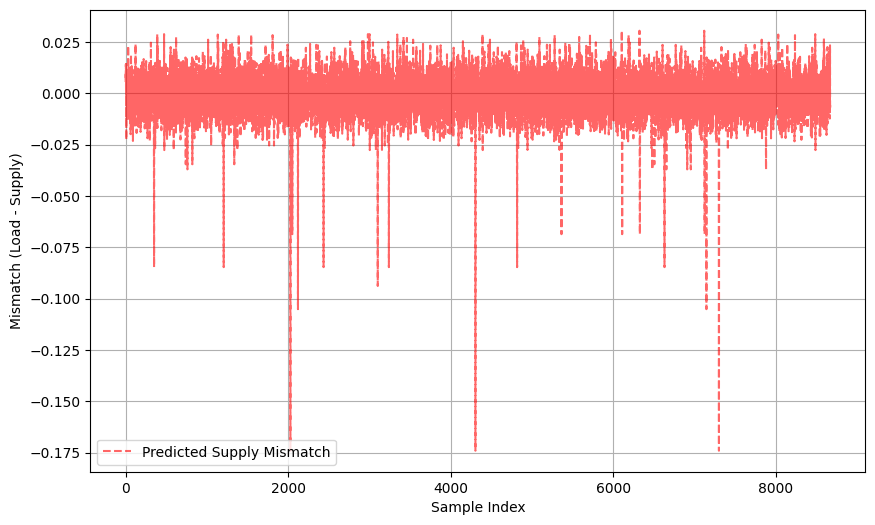

In [32]:
# insert code here

plt.figure(figsize=(10, 6))
plt.plot(predicted_mismatch, label="Predicted Supply Mismatch", color="red", linestyle="--", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Mismatch (Load - Supply)")
plt.legend()
plt.grid(True)
plt.show()

## GNN Training



### 1. Load network topology data and create graph

In [33]:
# Insert file path for the network data file (xlsx file)
data_file = "IEEE_14_bus_Data 1.xlsx"

In [34]:
# first we need to import the network data to understand how the power grid graph looks like

def read_data(File='IEEE_14_bus_Data.xlsx',print_data=False,DemFactor=1.0,LineLimit=1.0):
    # read the data file and convert it into a dictionary of dataframes

    Sbase=100

    data={}

    Bus=pd.read_excel(File,sheet_name='Bus',skiprows=0,index_col=[0],usecols='A')
    Bus=list(Bus.index)

    branch=pd.read_excel(File,sheet_name='Branch',skiprows=1,index_col=[0,1,2],usecols='A:F')
    line=pd.read_excel(File,sheet_name='Branch',skiprows=1,index_col=0,usecols='A')
    line=list(line.index)

    branch['limit']=(LineLimit*branch['limit'])/Sbase

    br_list=list(branch.index)
    Lines=gp.tuplelist(br_list)

    data['Bus']=Bus
    data['branch']=branch
    data['Lines']=Lines
    data['line']=line


    return data


In [35]:
data_x_bus = read_data(File=data_file,DemFactor=1.0,print_data=False)

In [36]:
# function to build networkx graph from adjacency matrix
def Build_graph(data,weighted=False):

    nodes=data['Bus']
    Lines=data['Lines']

    node_list=nodes.copy()

    graph=nx.Graph()

    if weighted==False:
        edge_list=[]
        for l,i,j in Lines:
            graph.add_edge(i, j, weight=1)

        graph.add_nodes_from(node_list)

    if weighted==True:
        edge_list=[]
        for l,i,j in Lines:
            graph.add_edge(i, j, weight=data['branch'].loc[(l,i,j)]['x'])

        graph.add_nodes_from(node_list)
        graph.add_edges_from(edge_list)

    return graph

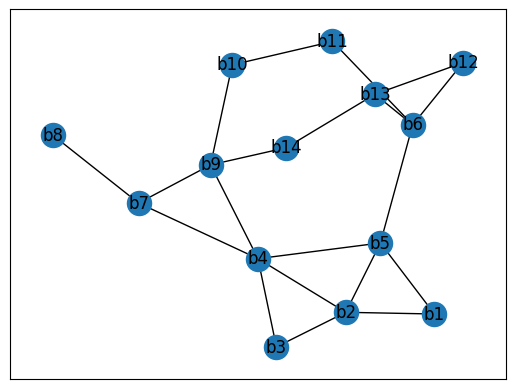

In [37]:
graph=Build_graph(data_x_bus, weighted=False)
nx.draw_networkx(graph)

### 2. Create GNN Model and Data

In [38]:
#function to create graph datasets

def create_graph_data(graph,input_x,output_x, edge_list):

    dataset = []
    edge_list = [[edge[0], edge[1]] for edge in edge_list]
    edge_list = torch.tensor(np.array(edge_list).T, dtype=torch.int64)

    for i in range(input_x.shape[0]):
            dataset.append(Data(x=input_x[i].float(), y=output_x[i].float(), edge_index=edge_list))

    return dataset

In [39]:
## create edge attributes for network
edge_labels = nx.get_edge_attributes(graph, "weight")
edge_list = [i for i in edge_labels.keys() ]

edge_list = [(i[0][1:], i[1][1:]) for i in edge_list]
edge_list = [(int(i[0])-1, int(i[1])-1) for i in edge_list]

In [40]:
train_dataset = create_graph_data(graph,train_x, train_y,edge_list)
val_dataset = create_graph_data(graph,val_x, val_y,edge_list)
test_dataset = create_graph_data(graph,test_x, test_y,edge_list)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
# Function to create a simple GNN, the output of convolutional layers are passed through linear layers to get the correct output shape
class VanillaGNN(torch.nn.Module):

    def __init__(self, network_size, num_features, num_of_outputs,conv_hid_features=32, lin_hid_features=256):
        super(VanillaGNN, self).__init__()
        self.network_size = network_size
        self.num_features = num_features
        self.conv_hid_features = conv_hid_features
        self.lin_hid_features = lin_hid_features
        self.output_dim = num_of_outputs


        self.conv1 = ChebConv(self.num_features, self.conv_hid_features, K=3)
        self.conv2 = ChebConv(self.conv_hid_features, self.conv_hid_features, K=3)
        self.conv3 = ChebConv(self.conv_hid_features, self.conv_hid_features, K=3)


        self.lin1 = Linear(self.conv_hid_features*(self.network_size), self.lin_hid_features)
        self.lin2 = Linear(self.lin_hid_features,self.output_dim)


    def forward(self, data):

        x = data.x[:]

        x = x.reshape(-1,1)

        edge_index = data.edge_index
        batch_size = int(len(data.batch)/self.network_size)

        x = self.conv1(x=x, edge_index=edge_index)
        x = x.relu()
        x = self.conv2(x=x, edge_index=edge_index)
        x = x.relu()

        x=x.reshape(batch_size,-1)

        x = self.lin1(x)

        x = self.lin2(x)

        output = torch.flatten(x)

        output = output.float()

        return output

### 3. Adapt functions

In [42]:
# function to train GNN model , returns loss per epoch after summing loss per batch and dividing by number of batches in data loader object.
def train_gnn(model, loader, optimizer, device=device):
    model.to(device)
    model.train()

    epoch_loss = 0

    for batch in loader:
        data = batch.to(device)
        y = batch.y.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        y_pred = y_pred.to(device)
        loss = simple_loss(y_pred, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [43]:
# function for model evaluation
def evaluate_gnn(model, loader, device=device):


    torch.no_grad()
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    epoch_loss = 0

    model.eval()

    with torch.no_grad():

        for batch in loader:

            data = batch.to(device)
            y = batch.y.to(device)
            y_pred = model(data)
            y_pred = y_pred.to(device)
            loss = simple_loss(y_pred, y)
            epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [44]:
# function to run trained model through test data
def test_gnn(model, loader, device=device):

    torch.no_grad()
    model.to(device)

    epoch_loss = 0
    model_preds = []
    actual_y = []

    model.eval()

    with torch.no_grad():

        for batch in loader:

            data = batch.to(device)
            y = batch.y.to(device)
            actual_y.append(y)
            y_pred = model(data)
            model_preds.append(y_pred)
            y_pred = y_pred.to(device)
            loss = simple_loss(y_pred, y)
            epoch_loss += loss.item()

    return epoch_loss / len(loader), model_preds, actual_y

### 4. Training

Here we train the GNN model

### 4. Task

Train the model using the functions above

Epoch: 0
	Train Loss: 0.002
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.001
	 Val. Loss: 0.001
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.001
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000
test loss: 0.00040840329477246474


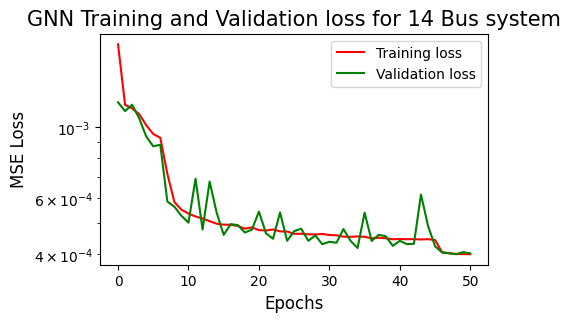

In [45]:
trained_GNN_models = []

network_size = 14
num_features = 1
num_of_outputs = 5
conv_hid_features = 32
lin_hid_features = 256

#create simple model instance
model_GNN = VanillaGNN(network_size, num_features, num_of_outputs,conv_hid_features, lin_hid_features)

# specify optimizer and other model details
optimizer = torch.optim.Adam(model_GNN.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

training_losses = []
validation_losses = []
best_valid_loss = float('inf')
early_stop_thresh = 20
epochs = 50
best_epoch = -1
for epoch in range(epochs+1):
  train_loss = train_gnn(model_GNN, train_loader, optimizer)
  valid_loss = evaluate_gnn(model_GNN, val_loader)
  training_losses.append(train_loss)
  validation_losses.append(valid_loss)

  scheduler.step(valid_loss)

  if epoch % 10 == 0:
      print(f'Epoch: {epoch}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f}')
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss

training_losses=np.array(training_losses)
validation_losses=np.array(validation_losses)

plt.subplots(figsize=(5,3))
plt.plot([i for i in range(len(training_losses))], training_losses, 'r', label='Training loss')
plt.plot([i for i in range(len(validation_losses))], validation_losses, 'g', label='Validation loss')
plt.legend()
plt.title(f'GNN Training and Validation loss for 14 Bus system',fontsize = 15)
plt.xlabel('Epochs',fontsize = 12)
plt.ylabel('MSE Loss',fontsize = 12)
plt.semilogy()

test_loss, model_preds,actual_y = test_gnn(model_GNN, test_loader)

trained_GNN_models.append(model_GNN)
print("test loss:", np.array(test_loss))



### 5. Understand predictions

To ensure the model is working as we would expect, perform the following sanity checks:

### Task 5

1.   Finally for the GNN model, check how well the power balance constraint is satisfied by computing the maximum and mean power balance mismatches
2.   Plot the error distribution and comment on the type of distribution



In [79]:
flat_model_preds = [tensor.cpu().numpy().flatten() for tensor in model_preds]
flat_model_preds = [item for sublist in flat_model_preds for item in sublist]  # Flatten the list
flat_model_preds = np.array(flat_model_preds).reshape(len(test_x), 5) # Reshape to (number of samples, 5)
print(len(test_x))
print(len(flat_model_preds))
print('I just checked for equal lengths!')
# Compute power balance mismatch
predicted_mismatch = []

for i in range(len(test_x)):
    a = sum(test_x[i]) #x is the sum of all load demands on a row
    b = sum(flat_model_preds[i]) #y is the sum of all generator supplies on a row
    predicted_mismatch.append(compute_power_balance_mismatch(a, b))

max_predicted_mismatch = np.max(np.abs(predicted_mismatch))
mean_predicted_mismatch = np.mean(np.abs(predicted_mismatch))

print('Maximum power balance mismatch between the load demand and predicted generator supply is: ', max_predicted_mismatch)
print('Mean power balance mismatch between the load demand and predicted generator supply is: ', mean_predicted_mismatch)

#power_balance_mismatch = compute_power_balance_mismatch(test_x, flat_model_preds)
#max_predicted_mismatch = torch.max(torch.abs(power_balance_mismatch)).item()
#mean_predicted_mismatch = torch.mean(torch.abs(power_balance_mismatch)).item()
#print('Maximum power balance mismatch between the load demand and predicted generator supply is: ', max_predicted_mismatch)
#print('Mean power balance mismatch between the load demand and predicted generator supply is: ', mean_predicted_mismatch)

8672
8672
I just checked for equal lengths!
Maximum power balance mismatch between the load demand and predicted generator supply is:  0.14155924
Mean power balance mismatch between the load demand and predicted generator supply is:  0.014117356


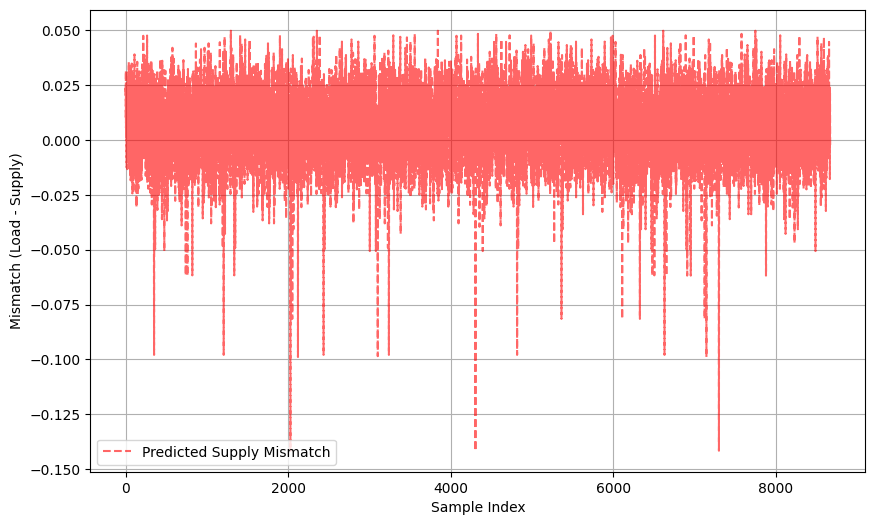

In [83]:
# insert code here

plt.figure(figsize=(10, 6))
plt.plot(predicted_mismatch, label="Predicted Supply Mismatch", color="red", linestyle="--", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Mismatch (Load - Supply)")
plt.legend()
plt.grid(True)
plt.show()

### 6. Compare models

Compare the best FNN model from the previous section to the GNN model here based on the number of parameters the models have. Use the function provided below

In [84]:
# count the number of parameters in a model
def count_model_parameters(model):
  tot_params = 0
  for parameter in model.parameters():
      layer_ws = 1
      for val in parameter.shape:
          layer_ws*=val
      tot_params += layer_ws
  print(f"Total number of parameters = {tot_params}")

### Task 6
Which of the two models is more parameter efficient?

In [85]:
print("FNN Model:")
count_model_parameters(trained_models[0])

print()

print("GNN Model:")
count_model_parameters(trained_GNN_models[0])

FNN Model:
Total number of parameters = 1141

GNN Model:
Total number of parameters = 122565


In this case the **FNN model is more parameter efficient**. This makes sense cause while GNNs are good with graph-structured data and focus on situations where the relationships between nodes matter (like power grids), FNNs are simpler and better at dealing with tabular data or simple inputs in general.

# END